In [1]:
# Enable loading of levers module
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [2]:
import random
from itertools import combinations
from copy import deepcopy

import torch
import matplotlib.pyplot as plt

from levers import IteratedLeverEnvironment
from levers.learner import DRQNetwork, DRQNAgent
from levers.helpers import generate_binary_patterns
from levers.partners import FixedPatternPartner

In [3]:
def train_drqn_agent(train_partners):
    # Environment settings
    payoffs = [1., 1.]
    truncated_length = 100

    # Learner settings
    hidden_size = 4
    capacity = 8
    batch_size = 4
    lr = 0.01
    gamma = 0.99
    len_update_cycle = 4
    tau = 5e-4

    # Training settings
    num_episodes = 1000
    epsilon = 0.3

    # Construct list of environments to train on
    train_envs = [
        IteratedLeverEnvironment(
            payoffs, truncated_length+1, FixedPatternPartner(list(pattern)),
            False, False)
        for pattern in train_partners
    ]

    # Reset learner
    learner = DRQNAgent(
        DRQNetwork(
            input_size=len(train_envs[0].dummy_obs()),
            hidden_size=hidden_size,
            n_actions=train_envs[0].n_actions()),
        capacity, batch_size, lr, gamma, len_update_cycle, tau
    )

    # Train learner
    for episode in range(num_episodes):
        # Sample reset environment from training environments
        env = random.sample(train_envs, 1)[0]
        obs = env.reset()
        learner.reset_trajectory_buffer(init_obs=obs)

        # Step through environment
        for step in range(truncated_length):
            action = learner.act(obs, epsilon)
            next_obs, reward, done = env.step(action)
            learner.update_trajectory_buffer(action, reward, next_obs, done)
            obs = next_obs 

        # Flush experience to replay memory and train learner
        learner.flush_trajectory_buffer()
        learner.train()

    return learner

In [4]:
def eval_drqn_xplay(learner1, learner2):
    # Environment parameters
    payoffs = [1., 1.]
    truncated_length = 100

    # Initialize environment without lever game partner
    env = IteratedLeverEnvironment(
        payoffs,
        truncated_length+1, 
        include_payoffs=False,
        include_step=False
    )

    # Reset learners' hidden states
    learner1.hidden = None
    learner2.hidden = None

    ret = 0
    joint_obs = env.reset()
    obs1 = joint_obs[0,]
    obs2 = joint_obs[1,]

    for _ in range(truncated_length):
        action1 = learner1.act(obs1)
        action2 = learner2.act(obs2)

        joint_next_obs, reward, done = env.step([action1, action2])

        obs1 = joint_next_obs[0,]
        obs2 = joint_next_obs[1,]

        ret += reward

    return ret / truncated_length


In [5]:
# Number of agents for crossplay
n_agents = 20

# Train agents
patterns = generate_binary_patterns(length=3)
train_partners = random.sample(list(combinations(patterns, 4)), n_agents)
agents = []
print('Training DRQN agent: ', end='')
for agent_id in range(n_agents):
    end = '.\n' if agent_id == n_agents - 1 else ' '
    print(f'{agent_id}', end=end) 
    agents.append(train_drqn_agent(train_partners[agent_id]))

Training DRQN agent: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19.


In [6]:
# Evaluate agents in crossplay
scores = torch.zeros((n_agents, n_agents))
for a1_idx in range(n_agents):
    for a2_idx in range(n_agents):
        # Copy DRQN agents to ensure that acting doesn't unexpectedly influence
        # internal states
        agents[a1_idx].hidden = None
        agents[a2_idx].hidden = None
        learner1 = deepcopy(agents[a1_idx])
        learner2 = deepcopy(agents[a2_idx])
        scores[a1_idx, a2_idx] = eval_drqn_xplay(learner1, learner2)

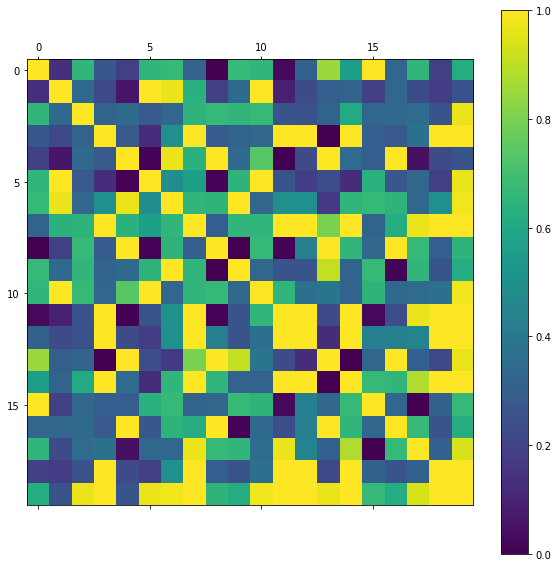

In [7]:
# Draw crossplay matrix
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(scores, vmin=0, vmax=1)
fig.colorbar(cax)